# Project 4: Machine Learning Fairness

In this project, we use the COMPAS dataset to compare two different machine learning algorithms.

In [115]:
# set up numba jit (GPU processing)
!apt-get install nvidia-cuda-toolkit
!pip3 install numba

import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/lib/nvidia-cuda-toolkit/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/lib/x86_64-linux-gnu/libnvvm.so"

from numba import cuda
import numpy as np
import time

@cuda.jit
def hello(data):
    data[cuda.blockIdx.x, cuda.threadIdx.x] = cuda.blockIdx.x

numBlocks = 5
threadsPerBlock = 10

data = np.ones((numBlocks, threadsPerBlock), dtype=np.uint8)

hello[numBlocks, threadsPerBlock](data)

print(data)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
nvidia-cuda-toolkit is already the newest version (11.5.1-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
[[0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3 3 3 3]
 [4 4 4 4 4 4 4 4 4 4]]


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 5 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [116]:
# from numba.decorators import jit
from numba import jit

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
import numpy as np
from scipy.spatial.distance import cdist
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import scipy.optimize as optim
from sklearn.metrics import confusion_matrix
pd.set_option("display.max_columns", None)
import missingno as msno
from datetime import datetime
import seaborn as sns
import time
import os
import io
import pickle

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## COMPAS Dataset

This was taken from https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis

After going into their github page, the "compas-scores-two-years.csv" file was used.

The scope of this project entails the subset of Caucasians and African Americans so that iss what we will examine.

In [118]:
# from google.colab import files
# uploaded = files.upload()

In [119]:
df =pd.read_csv('https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv')

In [120]:
#df = pd.read_csv(io.StringIO(uploaded['compas-scores-two-years.csv'].decode('utf-8')))

#drop unnessary rows and columns

#only keep Caucasian and African-American subset
df = df.loc[(df['race'] == 'African-American') | (df['race'] == 'Caucasian')]
#drop all columns except x column 'race' and y column "two-year-recid"
#df = df[['race', 'two_year_recid']]

In [121]:
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,0,6,0,0,14,-1.0,2014-02-18 05:08:24,2014-02-24 12:18:30,14002304CF10A,2014-02-18,NaN,1.0,F,Possession Burglary Tools,1,14004485CF10A,(F2),0.0,2014-03-31,Poss of Firearm by Convic Felo,2014-03-31,2014-04-18,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,6,Medium,2014-02-19,Risk of Violence,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
8,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,0,1,0,0,0,-1.0,2014-03-15 05:35:34,2014-03-18 04:28:46,14004524MM10A,2014-03-15,NaN,1.0,M,Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2014-03-16,Risk of Violence,1,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0


In [122]:
#keep certain columns
selected_columns=['sex', 'age', 'race', 'juv_fel_count', 'decile_score',
                  'juv_misd_count', 'juv_other_count', 'priors_count',
                  'c_charge_degree', 'days_b_screening_arrest',
                   'v_decile_score',
                    'priors_count.1',
                  'start', 'end', 'event', 'two_year_recid']
df = df[selected_columns]

In [123]:
df.head()

,sex,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,c_charge_degree,days_b_screening_arrest,v_decile_score,priors_count.1,start,end,event,two_year_recid
1,Male,34,African-American,0,3,0,0,0,F,-1.0,1,0,9,159,1,1
2,Male,24,African-American,0,4,0,1,4,F,-1.0,3,4,0,63,0,1
3,Male,23,African-American,0,8,1,0,1,F,NaN,6,1,0,1174,0,0
6,Male,41,Caucasian,0,6,0,0,14,F,-1.0,2,14,5,40,1,1
8,Female,39,Caucasian,0,1,0,0,0,M,-1.0,1,0,2,747,0,0


In [124]:
# one hot encode categorical columns
# Check which columns are categorical and which are not
categorical_columns = df.select_dtypes(include=['object']).columns
df_one_hot = pd.get_dummies(df, columns=categorical_columns)
df_one_hot = df_one_hot.replace({True: 1, False: 0})
df_one_hot = df_one_hot.fillna(0)

In [125]:
df_one_hot = df_one_hot.drop(columns=['race_Caucasian'])
df_one_hot.head()

,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,v_decile_score,priors_count.1,start,end,event,two_year_recid,sex_Female,sex_Male,race_African-American,c_charge_degree_F,c_charge_degree_M
1,34,0,3,0,0,0,-1.0,1,0,9,159,1,1,0,1,1,1,0
2,24,0,4,0,1,4,-1.0,3,4,0,63,0,1,0,1,1,1,0
3,23,0,8,1,0,1,0.0,6,1,0,1174,0,0,0,1,1,1,0
6,41,0,6,0,0,14,-1.0,2,14,5,40,1,1,0,1,0,1,0
8,39,0,1,0,0,0,-1.0,1,0,2,747,0,0,1,0,0,0,1


## Data separation for training and testing

training_sensitive, training_nonsensitive, ytrain_sensitive, ytrain_nonsensitive

In [126]:
data = df_one_hot.to_numpy()

In [127]:
# sensitive group column
df_one_hot.columns.get_loc("race_African-American")

15

In [128]:
y = df_one_hot.loc[:,"two_year_recid"]
y_sensitive = df_one_hot.loc[df_one_hot['race_African-American'] == 1, 'two_year_recid']
y_nonsensitive = df_one_hot.loc[df_one_hot['race_African-American'] == 0, 'two_year_recid']
df_one_hot = df_one_hot.drop(columns=['two_year_recid'])

data_sensitive = df_one_hot[df_one_hot['race_African-American'] == 1]
data_sensitive = data_sensitive.drop(columns=['race_African-American'])
data_nonsensitive = df_one_hot[df_one_hot['race_African-American'] == 0]
data_nonsensitive = data_nonsensitive.drop(columns=['race_African-American'])

In [129]:
# 80 - 20 training test split
total_n = len(y)
sensitive_n = data_sensitive.shape[0]
nonsensitive_n = data_nonsensitive.shape[0]

train_sensitive_idx = int(sensitive_n *.8)
test_sensitive_idx = int(sensitive_n - train_sensitive_idx)
train_nonsensitive_idx = int(nonsensitive_n *.8)
test_nonsensitive_idx = int(nonsensitive_n - train_nonsensitive_idx)

In [138]:
training_sensitive = data_sensitive[:train_sensitive_idx+1].to_numpy()
training_nonsensitive = data_nonsensitive[:train_nonsensitive_idx].to_numpy()

y_train_sensitive = y_sensitive[:train_sensitive_idx+1].to_numpy()
y_train_nonsensitive = y_nonsensitive[:train_nonsensitive_idx+1].to_numpy()

test_sensitive = data_sensitive[train_sensitive_idx+1:].to_numpy()
test_nonsensitive = data_nonsensitive[train_nonsensitive_idx+1:].to_numpy()

y_test_sensitive = y_sensitive[train_sensitive_idx+1:].to_numpy()
y_test_nonsensitive = y_nonsensitive[train_nonsensitive_idx+1:].to_numpy()

## Algorithm 1: Learning Fair Representations

Article can be sourced here: http://proceedings.mlr.press/v28/zemel13.html

Using the algorithm described in the above paper, we attempt to predict the two_year_recid rate.

The main idea is to encode the data as much as possible while obfuscating any individual's belonging to a particular membership group. We want to maintain as much information about the individual as possible but lose any information that can identify if they belong to a particular subgroup.

This is done by mapping each individual, represented as a data point in a given input space, to a probability distribution in a new representation space.

There are several goals:

1. satisfy statistical parity (must maintain that both subgroups map to the same prototype with same frequency)
2. retain information except about subgroup identity
3. induced mapping is accurate

The code has two parts:
1. mapping X to prototype Z - this learning algorithm learns prototype Z while maintaining statistical parity
2. Use prototype Z to map to Y


## Statistical Equations

See Zemel Paper (http://proceedings.mlr.press/v28/zemel13.pdf)
- M_nk = (2)
- x_n_hat = (9)
- L_x = (8)
- y_hat_n = (11)
- L_y = (10)

In [131]:
# takes collection of vectors x in X
# default alpha[p] should be 1 (simple Euclidean distance)
# X - array [0...N] of individual data vectors [0...P]
# v - prototype cluster representative vector
# N - number of data
# P - number of characteristics
# k - number of prototypes
# Returns distance vector dist[i,j] = distance between ith X and v_j
@jit
def distances(X, v, alpha, N, P, k):
    dists = np.zeros((N, P))
    for i in range(N):
        for p in range(P):
            for j in range(k):
                dists[i, j] += ((X[i, p] - v[j, p])**2) * alpha[p]
    return dists

# Probability beloning to kth prototype given x_n
# dists - distributions of prototypes
# N - number of data
# k - number of prototypes
# Returns M_nk = Pr(Z = k|x_n)
@jit
def M_nk(dists, N, k):
    M_nk = np.zeros((N, k))
    exp = np.zeros((N, k))
    denom = np.zeros(N)

    for i in range(N):
        for j in range(k):
            exp[i, j] = np.exp(-1 * dists[i, j])
            denom[i] += exp[i, j]
        for j in range(k):
            if denom[i]: #possibility it is 0, catch undefined
                M_nk[i, j] = exp[i, j] / denom[i]
            else:
                M_nk[i, j] = exp[i, j] / 1e-6
    return M_nk


# M_nk = Pr(Z = k|x_n)
# N - number of data
# k - number of prototypes
# Returns M_k = probability belong to prototype k
@jit
def M_k(M_nk, N, k):
    M_k = np.zeros(k)

    for i in range(N):
        for j in range(k):
            M_k[j] += M_nk[i, j]
        M_k[j] = M_k[j]/N
    return M_k

# newly captured information about x
# original x_n --> x_n_hat (newly mapped x_n)
# calcualted by probabilty of beloning to kth prototype * kth prototype vector representation
# L_x = loss of information going from x_n to x_n_hat
@jit
def x_n_hat(X, M_nk, v, N, P, k):
    x_n_hat = np.zeros((N, P))
    L_x = float(0)
    for i in range(N):
        for p in range(P):
            for j in range(k):
                x_n_hat[i, p] += M_nk[i, j] * v[j, p]
            L_x += (X[i, p] - x_n_hat[i, p]) * (X[i, p] - x_n_hat[i, p])
    return x_n_hat, L_x

# y_hat_n = prediction for x_n -> y_n (the equivalent of y_n)
# weighted sum of each prototypes prediction for y
# (this is not the final prediction and is later softmaxed)
# L_y is the loss
@jit
def yhat(M_nk, y, w, N, k):
    yhat = np.zeros(N)
    L_y = 0.0
    for i in range(N):
        for j in range(k):
            yhat[i] += M_nk[i, j] * w[j]
        # constrain bounds
        if yhat[i] <= 0:
            yhat[i] = 1e-6
        elif yhat[i] >= 1:
            yhat[i] = 0.999999

        L_y += -1 * y[i] * np.log(yhat[i]) - (1.0 - y[i]) * np.log(1.0 - yhat[i])
    return yhat, L_y

<ipython-input-131-15316182c898>:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def distances(X, v, alpha, N, P, k):
<ipython-input-131-15316182c898>:24: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def M_nk(dists, N, k):
<ipython-input-131-15316182c898>:46: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorato

In [132]:
# Learning Fair Representations - the Loss function
# params = (default) paramters to train on
# k - number of prototype clusters
# A_x, A_y, A_Z = default alpha values
# returns criterion (the Loss function to optimize)
@jit
def LFR(params, data_sensitive, data_nonsensitive, y_sensitive,
        y_nonsensitive,  k=10, A_x = 1e-4, A_y = 0.1, A_z = 1000, results=0):

    LFR.iters += 1
    Ns, P = data_sensitive.shape
    Nns, _ = data_nonsensitive.shape

    alpha0 = params[:P]
    alpha1 = params[P : 2 * P]
    w = params[2 * P : (2 * P) + k]

    # define default vectors for v
    v = np.matrix(params[(2 * P) + k:]).reshape((k, P))

    dists_sensitive = distances(data_sensitive, v, alpha1, Ns, P, k)
    dists_nonsensitive = distances(data_nonsensitive, v, alpha0, Nns, P, k)

    M_nk_sensitive = M_nk(dists_sensitive, Ns, k)
    M_nk_nonsensitive = M_nk(dists_nonsensitive, Nns, k)

    M_k_sensitive = M_k(M_nk_sensitive, Ns, k)
    M_k_nonsensitive = M_k(M_nk_nonsensitive, Nns, k)


    L_z = 0.0
    for j in range(k):
        L_z += abs(M_k_sensitive[j] - M_k_nonsensitive[j])

    x_n_hat_sensitive, L_x1 = x_n_hat(data_sensitive, M_nk_sensitive, v, Ns, P, k)
    x_n_hat_nonsensitive, L_x2 = x_n_hat(data_nonsensitive, M_nk_nonsensitive, v, Nns, P, k)
    L_x = L_x1 + L_x2

    yhat_sensitive, L_y1 = yhat(M_nk_sensitive, y_sensitive, w, Ns, k)
    yhat_nonsensitive, L_y2 = yhat(M_nk_nonsensitive, y_nonsensitive, w, Nns, k)
    L_y = L_y1 + L_y2

    criterion = A_x * L_x + A_y * L_y + A_z * L_z

    if LFR.iters % 250 == 0:
        print(LFR.iters, criterion)

    if results:
        return yhat_sensitive, yhat_nonsensitive, M_nk_sensitive, M_nk_nonsensitive
    else:
        return criterion

LFR.iters = 0

<ipython-input-132-087853dea02f>:7: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def LFR(params, data_sensitive, data_nonsensitive, y_sensitive,


In [133]:
k = 10 # arbitrary number of prototype clusters
P = 16 # number of columns (characteristics we care about)
# rez = np.random.uniform(size=data.shape[1] * 2 + k + data.shape[1] * k) #initial guess
rez = np.random.uniform(size=P * 2 + k + P * k) #initial guess

bnd = []
for i, k2 in enumerate(rez):
    if i < data.shape[1] * 2 or i >= data.shape[1] * 2 + k:
        bnd.append((None, None))
    else:
        bnd.append((0, 1))

In [134]:
optimal_params, min_L,_ = optim.fmin_l_bfgs_b(LFR, x0=rez, epsilon=1e-5,
                          args=(training_sensitive, training_nonsensitive,
                                y_train_sensitive, y_train_nonsensitive, k, 1e-4,
                                0.1, 1000, 0),
                          bounds = bnd, approx_grad=True, maxfun=150000,
                          maxiter=150000)

<ipython-input-132-087853dea02f>:6: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "LFR" failed type inference due to: Unknown attribute 'iters' of type recursive(type(CPUDispatcher(<function LFR at 0x7da7b187d900>)))

File "<ipython-input-132-087853dea02f>", line 10:
def LFR(params, data_sensitive, data_nonsensitive, y_sensitive, 
    <source elided>
    
    LFR.iters += 1 
    ^

During: typing of get attribute at <ipython-input-132-087853dea02f> (10)

File "<ipython-input-132-087853dea02f>", line 10:
def LFR(params, data_sensitive, data_nonsensitive, y_sensitive, 
    <source elided>
    
    LFR.iters += 1 
    ^

  @jit
/usr/local/lib/python3.10/dist-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "LFR" was compiled in object mode without forceobj=True.

File "<ipython-input-132-087853dea02f>", line 7:
@jit
def LFR(params, data_sensitive, data_nonsensitive, y_sensitive, 
^

  warnings.warn(errors.NumbaWarn

250 237006.34477444936
500 228096.31033380266
750 228094.533817871
1000 228083.25781389818
1250 228062.2643292187
1500 228061.1303907679
1750 228064.45391591205
2000 228060.90520079667
2250 228060.80492242915
2500 228061.31690806983
2750 228060.6892047635
3000 228061.54330562282
3250 228063.041049589
3500 228061.43757004986
3750 228060.60829176643
4000 228061.6045577603
4250 228060.59197148864
4500 228060.59743089092
4750 228060.59203403036
5000 228060.5598910171
5250 228060.5811896946
5500 228060.59083199754
5750 228060.59162539046
6000 228060.59189890945
6250 228060.59200548433
6500 228060.5920363939
6750 228060.59206296448
7000 228060.59203445114
7250 228060.59203510007
7500 228060.5920399299
7750 228060.59203403015
8000 228060.5920340308
8250 228060.59203403024
8500 228060.59203405064
8750 228060.59202777344


In [135]:
# save parameters
with open('optimal_params.npy', 'wb') as f:
    np.save(f, optimal_params)
    np.save(f, min_L)

In [136]:
# given data and optimal parameters (learned from LFR, predict values)
def predict(optimal_params,data_sensitive, data_nonsensitive, y_sensitive, y_nonsensitive, k=10):
    Ns, P = data_sensitive.shape
    Nns, _ = data_nonsensitive.shape

    alpha0 = optimal_params[:P]
    alpha1 = optimal_params[P : 2 * P]
    w = optimal_params[2 * P : (2 * P) + k]

    # define default vectors for v
    v = np.matrix(optimal_params[(2 * P) + k:]).reshape((k, P))

    dists_sensitive = distances(data_sensitive, v, alpha1, Ns, P, k)
    dists_nonsensitive = distances(data_nonsensitive, v, alpha0, Nns, P, k)

    M_nk_sensitive = M_nk(dists_sensitive, Ns, k)
    M_nk_nonsensitive = M_nk(dists_nonsensitive, Nns, k)

    M_k_sensitive = M_k(M_nk_sensitive, Ns, k)
    M_k_nonsensitive = M_k(M_nk_nonsensitive, Nns, k)

    y_n_hat_sensitive, y_loss_sensitive = yhat(M_nk_sensitive, y_sensitive, w, y_sensitive.shape[0], k)
    y_n_hat_nonsensitive, y_loss_nonsensitive = yhat(M_nk_nonsensitive, y_nonsensitive, w, y_nonsensitive.shape[0], k)

    return y_n_hat_sensitive, y_loss_sensitive, y_n_hat_nonsensitive, y_loss_nonsensitive

## Model Evaluation

There are three ways to evaluate the model

1. Parity - probability of prediction for each group is the same
2. Calibration - probability of correctness for each group is the same
3. Equality of Odds - odds of prediction are the same for sensitive+ and nonsensitive+

### Parity

In [144]:
# training accuracy
ynhat_train_sensitive, ynhat_trainloss_sensitive, ynhat_train_nonsensitive, ynhat_trainloss_nonsensitive = predict(optimal_params,
                                                                                         training_sensitive,
                                                                                         training_nonsensitive,
                                                                                         y_train_sensitive, y_train_nonsensitive)
#get labels
y_train_sensitive_labels = [round(y) for y in ynhat_train_sensitive]
y_train_nonsensitive_labels = [round(y) for y in ynhat_train_nonsensitive]

In [145]:
# training parity
num_positive_sensitive = np.sum(y_train_sensitive_labels)
num_positive_nonsensitive = np.sum(y_train_nonsensitive_labels)

proportion_sensitive = num_positive_sensitive / len(y_train_sensitive_labels)
proportion_nonsensitive = num_positive_sensitive / len(y_train_nonsensitive_labels)

print("Sensitive proportion positive: ", proportion_sensitive)
print("Nonsensitive proportion positive: ", proportion_nonsensitive)

Sensitive proportion positive:  0.045992560027054444
Nonsensitive proportion positive:  0.06924643584521385


In [146]:
# testing accuracy
# training accuracy
ynhat_test_sensitive, ynhat_testloss_sensitive, ynhat_test_nonsensitive, ynhat_testloss_nonsensitive = predict(optimal_params,
                                                                                         test_sensitive,
                                                                                         test_nonsensitive,
                                                                                         y_test_sensitive,
                                                                                          y_test_nonsensitive)
#get labels
y_test_sensitive_labels = [round(y) for y in ynhat_test_sensitive]
y_test_nonsensitive_labels = [round(y) for y in ynhat_test_nonsensitive]

In [147]:
# test parity
num_positive_sensitive = np.sum(y_test_sensitive_labels)
num_positive_nonsensitive = np.sum(y_test_nonsensitive_labels)

proportion_sensitive = num_positive_sensitive / len(y_test_sensitive_labels)
proportion_nonsensitive = num_positive_sensitive / len(y_test_nonsensitive_labels)

print("Sensitive proportion positive: ", proportion_sensitive)
print("Nonsensitive proportion positive: ", proportion_nonsensitive)

Sensitive proportion positive:  0.04871447902571042
Nonsensitive proportion positive:  0.07346938775510205


### Calibration

In [140]:
# training accuracy
ynhat_train_sensitive, ynhat_trainloss_sensitive, ynhat_train_nonsensitive, ynhat_trainloss_nonsensitive = predict(optimal_params,
                                                                                         training_sensitive,
                                                                                         training_nonsensitive,
                                                                                         y_train_sensitive, y_train_nonsensitive)
#get labels
y_train_sensitive_labels = [round(y) for y in ynhat_train_sensitive]
y_train_nonsensitive_labels = [round(y) for y in ynhat_train_nonsensitive]

In [141]:
sensitive_differences = np.sum(y_train_sensitive_labels != y_train_sensitive)
y_sensitive_accuracy = sensitive_differences/len(y_train_sensitive_labels)

nonsensitive_differences = np.sum(y_train_nonsensitive_labels != y_train_nonsensitive)
y_nonsensitive_accuracy = nonsensitive_differences/len(y_train_nonsensitive)

print("Sensitive accuracy: ", y_sensitive_accuracy)
print("Nonsensitive accuracy: ", y_nonsensitive_accuracy)

Sensitive accuracy:  0.4680419343929658
Nonsensitive accuracy:  0.38238289205702647


In [142]:
# testing accuracy
# training accuracy
ynhat_test_sensitive, ynhat_testloss_sensitive, ynhat_test_nonsensitive, ynhat_testloss_nonsensitive = predict(optimal_params,
                                                                                         test_sensitive,
                                                                                         test_nonsensitive,
                                                                                         y_test_sensitive,
                                                                                          y_test_nonsensitive)
#get labels
y_test_sensitive_labels = [round(y) for y in ynhat_test_sensitive]
y_test_nonsensitive_labels = [round(y) for y in ynhat_test_nonsensitive]

In [143]:
# test accuracy
sensitive_differences = np.sum(y_test_sensitive_labels != y_test_sensitive)
y_sensitive_accuracy = sensitive_differences/len(y_test_sensitive_labels)

nonsensitive_differences = np.sum(y_test_nonsensitive_labels != y_test_nonsensitive)
y_nonsensitive_accuracy = nonsensitive_differences/len(y_test_nonsensitive_labels)

print("Sensitive accuracy: ", y_sensitive_accuracy)
print("Nonsensitive accuracy: ", y_nonsensitive_accuracy)

Sensitive accuracy:  0.4912043301759134
Nonsensitive accuracy:  0.35714285714285715


### Equal Odds

In [154]:
# train accuracy
sensitive_odds = np.sum(np.array(y_train_sensitive_labels)[y_train_sensitive==1])
sensitive_odds = sensitive_odds / len(y_train_sensitive_labels)

nonsensitive_odds = np.sum(np.array(y_train_nonsensitive_labels)[y_train_nonsensitive==1])
nonsensitive_odds = nonsensitive_odds / len(y_train_nonsensitive_labels)

print("Sensitive odds: ", sensitive_odds)
print("Nonsensitive odds: ", nonsensitive_odds)

Sensitive odds:  0.043963476496449105
Nonsensitive odds:  0.016293279022403257


In [153]:
# test accuracy
sensitive_odds = np.sum(np.array(y_test_sensitive_labels)[y_test_sensitive==1])
sensitive_odds = sensitive_odds / len(y_test_sensitive)

nonsensitive_odds = np.sum(np.array(y_test_nonsensitive_labels)[y_test_nonsensitive==1])
nonsensitive_odds = nonsensitive_odds / len(y_test_nonsensitive)

print("Sensitive odds: ", sensitive_odds)
print("Nonsensitive odds: ", nonsensitive_odds)

Sensitive odds:  0.044654939106901215
Nonsensitive odds:  0.02040816326530612


## Some Charts

### Confusion Matrices

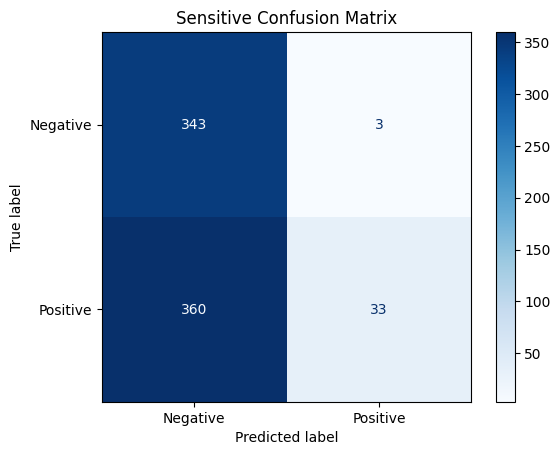

In [163]:
# Compute confusion matrix
cm = confusion_matrix(y_test_sensitive, y_test_sensitive_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Sensitive Confusion Matrix')
plt.show()

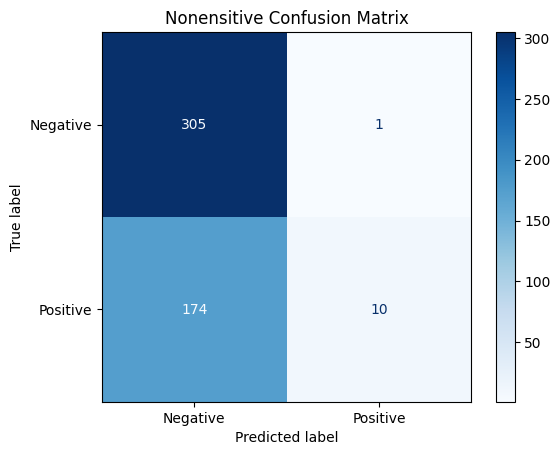

In [162]:
# Compute confusion matrix
cm = confusion_matrix(y_test_nonsensitive, y_test_nonsensitive_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Nonensitive Confusion Matrix')
plt.show()

### ROC Curves

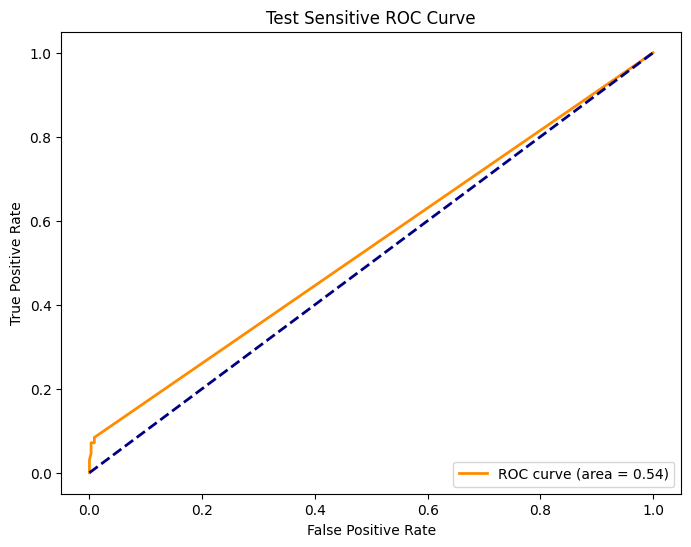

In [156]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_sensitive, ynhat_test_sensitive)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Sensitive ROC Curve')
plt.legend(loc='lower right')
plt.show()

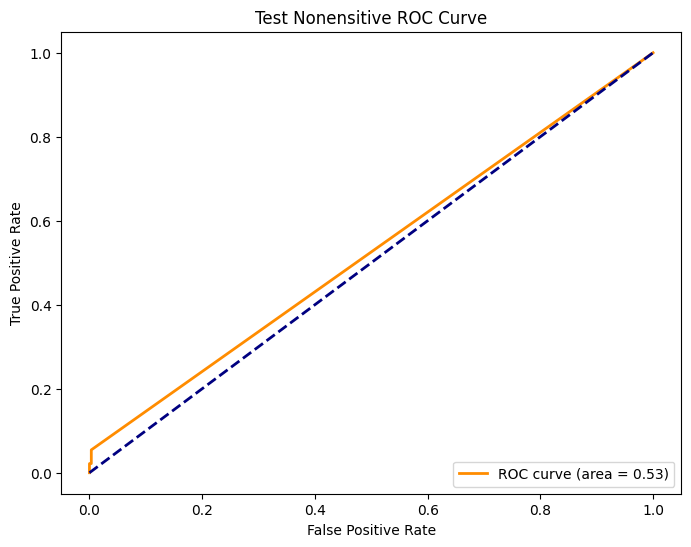

In [157]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_nonsensitive, ynhat_test_nonsensitive)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Nonensitive ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Conclusion

LFR satisfies parity and equal odds but not calibration